In [1]:
import os
from joblib import dump

# Helper functions for data preprocessing and feature extraction
from methods.preprocessing import *
from methods.image_enhancement import *

# Machine Learning models and utilities
from methods.ml import *

# CNN models and utilities
from methods.cnn import *

# 1. Preprocessing and EDA (Exploratory Data Analysis)

In [2]:
# Read data in folder
train_dir = "../data/fer-2013-data/train"
for dirpath,dirname,filenames in os.walk(train_dir):
    print(f"There are {len(dirname)} directories and {len(filenames)} images in {dirpath[22:]}")

There are 7 directories and 0 images in train
There are 0 directories and 3995 images in train\angry
There are 0 directories and 436 images in train\disgust
There are 0 directories and 4097 images in train\fear
There are 0 directories and 7215 images in train\happy
There are 0 directories and 4965 images in train\neutral
There are 0 directories and 4830 images in train\sad
There are 0 directories and 3171 images in train\surprise


In [3]:
data_gen = create_data_gen()
train_generator = data_gen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical"
)

Found 28709 images belonging to 7 classes.


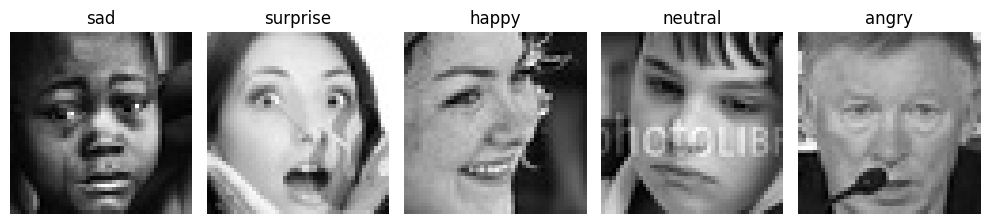

In [4]:
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items())

images, labels = next(train_generator)
plot_example_images(images[:5], labels[:5], label_map)

# 2. Traditional Image Processing/Enhancement

Optionally, enhance images or extract features.\
Traditional image processing and enhancement techniques are foundational to improving the quality of images for various applications, from medical imaging to photography.\
In our project, we modeled many of these techniques in the "image_enhancement.py" file. These are,
- Image inpainting
- Linear filtering, smoothing
- Histogram equalization
- ...

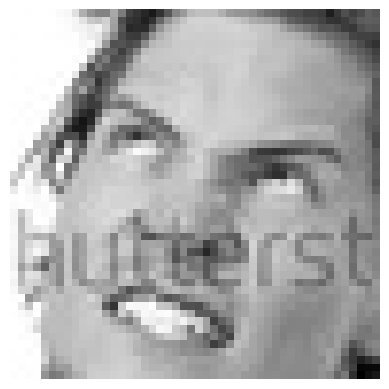

In [5]:
# This is an example image to show our enhancements on images
#improvable_image_path = "../data/fer-2013-data/train/angry/Training_2861857.jpg"
improvable_image_path = "../data/fer-2013-data/train/angry/Training_6640570.jpg"
show_image_as_plot(image_path=improvable_image_path)

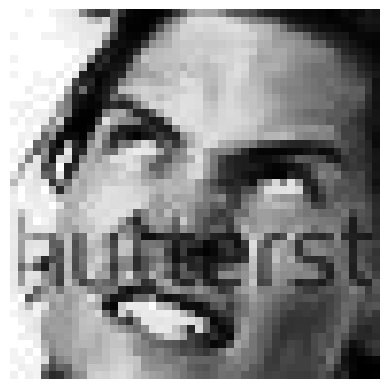

In [6]:
hist_equalized_image = histogram_equalization(image_path=improvable_image_path)
show_image_as_plot(image=hist_equalized_image)

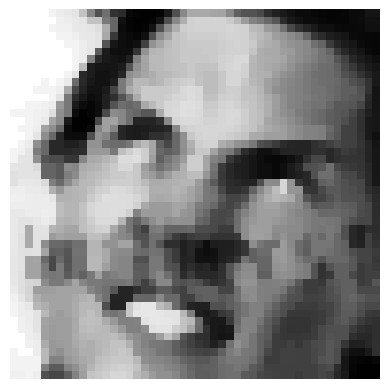

In [7]:
median_blur_image = reduce_noise_median(image=hist_equalized_image)
show_image_as_plot(image=median_blur_image)

# 3. Feature Matching

Feature matching is widely used in machine learning models.
In our project, we modeled two of these techniques in the "image_enhancement.py" file. These are,
- SIFT
- HOG

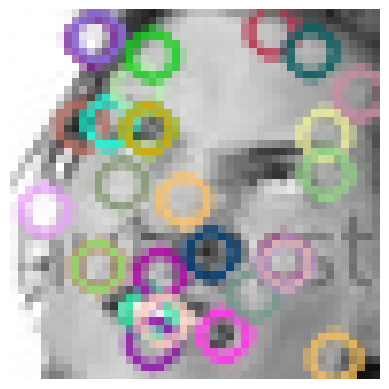

In [8]:
sift_img, _= sift_creator(image_path=improvable_image_path)
show_image_as_plot(image=sift_img)

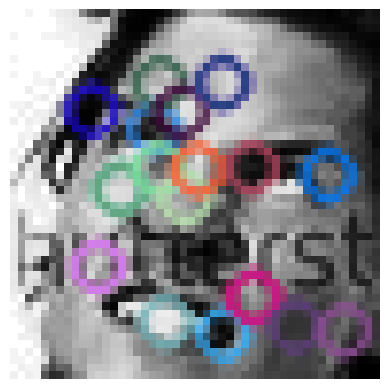

In [9]:
sift_img, _= sift_creator(image=hist_equalized_image)
show_image_as_plot(image=sift_img)

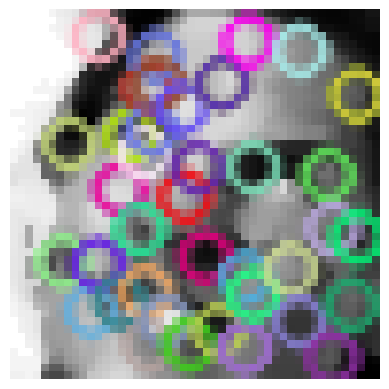

In [10]:
sift_img, _= sift_creator(image=median_blur_image)
show_image_as_plot(image=sift_img)

# 4. ML Models

We will train 3 different ML models and compare them.
- SVM
- KNN
- Random Forest

Improving model accuracy through techniques such as feature matching and cross-validation, which are crucial for assessing the performance of machine learning models like SVM, KNN, and Random Forest in a more robust manner.

In [11]:
# Load train dataset
images_train, labels_train = load_dataset(train_dir)

# Labels NumPy array
y_train = np.array(labels_train)

# Extract SIFT features
sift_features_train = extract_sift_features(images_train)
X_train_sift = np.array(sift_features_train)

# Extract HOG features
hog_features_train = extract_HOG_features(images_train)
X_train_hog = np.array(hog_features_train)

# Combine SIFT and HOG features
combined_features_train = combine_features(sift_features_train, hog_features_train)
X_train_combined = np.array(combined_features_train)

4.1. SVM (Support Vector Machine)

In [14]:
# sift + svm training
svm_classifier_sift = SVMClassifier()
svm_classifier_sift.train(X_train_sift, y_train)

# Save the trained model to a file
dump(svm_classifier_sift, "svm_classifier_sift.joblib")

In [ ]:
# hog + svm training
svm_classifier_hog = SVMClassifier()
svm_classifier_hog.train(X_train_hog, y_train)

# Save the trained model to a file
dump(svm_classifier_sift, "svm_classifier_hog.joblib")

In [ ]:
# combined + svm training
svm_classifier_combined = SVMClassifier()
svm_classifier_combined.train(X_train_combined, y_train)

# Save the trained model to a file
dump(svm_classifier_combined, "svm_classifier_combined.joblib")

4.2 KNN (K-Nearest Neighbors)

In [ ]:
# sift + knn training
knn_classifier_sift = KNNClassifier()
knn_classifier_sift.train(X_train_sift, y_train)

# Save the trained model to a file
dump(knn_classifier_sift, "knn_classifier_sift.joblib")

In [ ]:
# hog + knn training
knn_classifier_hog = KNNClassifier()
knn_classifier_hog.train(X_train_hog, y_train)

# Save the trained model to a file
dump(knn_classifier_hog, "knn_classifier_hog.joblib")

In [ ]:
# combined + knn training
knn_classifier_combined = KNNClassifier()
knn_classifier_combined.train(X_train_combined, y_train)

# Save the trained model to a file
dump(knn_classifier_combined, "knn_classifier_combined.joblib")

4.3 Random Forest

In [ ]:
# sift + random forest training
rf_classifier_sift = RandomForestClassifier()
rf_classifier_sift.train(X_train_sift, y_train)

# Save the trained model to a file
dump(rf_classifier_sift, "rf_classifier_sift.joblib")

In [ ]:
# hog + random forest training
rf_classifier_hog = RandomForestClassifier()
rf_classifier_hog.train(X_train_hog, y_train)

# Save the trained model to a file
dump(rf_classifier_hog, "rf_classifier_hog.joblib")

In [ ]:
# combined + random forest training
rf_classifier_combined = RandomForestClassifier()
rf_classifier_combined.train(X_train_combined, y_train)

# Save the trained model to a file
dump(rf_classifier_combined, "rf_classifier_combined.joblib")

# 5. CNN Models